In [1]:
import pandas as pd

# Load the uploaded file
file_path = "Layoffs.fyi - Tech Layoffs Tracker.csv"
df = pd.read_csv(file_path)

### Clean

In [3]:
# Convert 'Date' and 'Date Added' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Date Added'] = pd.to_datetime(df['Date Added'], errors='coerce')

In [4]:
# Clean '%' column
df['%'] = df['%'].astype(str).str.replace('%', '', regex=False)
df['%'] = pd.to_numeric(df['%'], errors='coerce')


In [5]:
# Clean '%' column: remove '%' and convert to float
df['%'] = df['%'].astype(str).str.replace('%', '', regex=False)
df['%'] = pd.to_numeric(df['%'], errors='coerce')

In [6]:
# Clean '$ Raised (mm)' column with parentheses to wrap multi-line method chaining
df['$ Raised (mm)'] = (
    df['$ Raised (mm)'].astype(str)
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
)
df['$ Raised (mm)'] = pd.to_numeric(df['$ Raised (mm)'], errors='coerce')

In [7]:
# Create 'Year' column from 'Date'
df['Year'] = df['Date'].dt.year

In [8]:
# Filter for 2022–2025
df_filtered = df[(df['Year'] >= 2022) & (df['Year'] <= 2025)]

In [9]:
# Show missing values in key columns
missing_summary = df_filtered[['Company', '# Laid Off', '%', 'Industry', 'Stage', '$ Raised (mm)', 'Country', 'Date']].isnull().sum()
print("Missing Values Summary:\n", missing_summary)

Missing Values Summary:
 Company             0
# Laid Off       1240
%                1239
Industry            1
Stage               7
$ Raised (mm)     394
Country             0
Date                0
dtype: int64


### EDA

In [13]:
import matplotlib.pyplot as plt


### Total Layoffs by Year

In [15]:
# Total layoffs by year
layoffs_per_year = df_filtered.groupby('Year')['# Laid Off'].sum().sort_index()
print(layoffs_per_year)

Year
2022    165269.0
2023    264220.0
2024    152922.0
2025     61220.0
Name: # Laid Off, dtype: float64


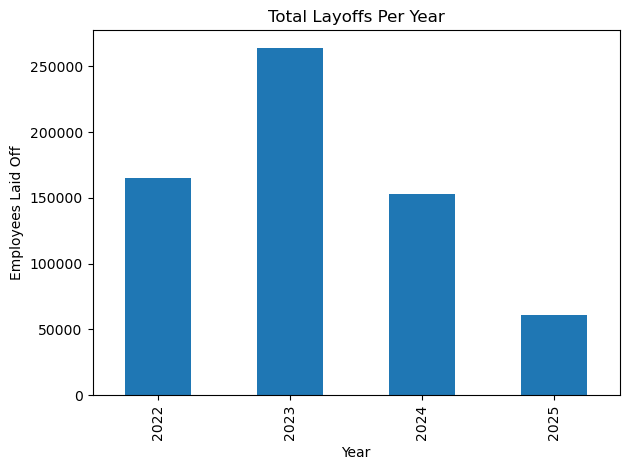

In [17]:
layoffs_per_year.plot(kind='bar', title='Total Layoffs Per Year', ylabel='Employees Laid Off', xlabel='Year')
plt.tight_layout()
plt.show()

### Total Layoffs by Months

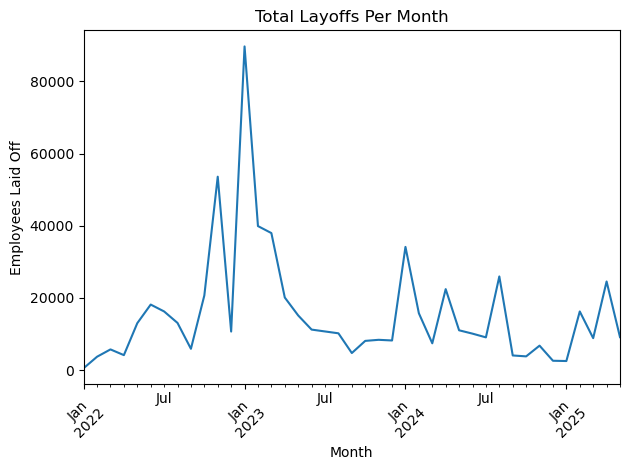

In [23]:
# Add this line before plotting by month
df_filtered.loc[:, 'Month'] = df_filtered['Date'].dt.to_period('M')

# Then proceed with the monthly aggregation and plot
layoffs_per_month = df_filtered.groupby('Month')['# Laid Off'].sum()

layoffs_per_month.plot(kind='line', title='Total Layoffs Per Month', ylabel='Employees Laid Off', xlabel='Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 Companies by Total Layoffs

Top 10 Companies:
 Company
Intel         38115.0
Amazon        27940.0
Meta          24700.0
Microsoft     20708.0
Tesla         14500.0
Cisco         14300.0
Google        13472.0
Dell          12650.0
Salesforce    11140.0
SAP           11000.0
Name: # Laid Off, dtype: float64


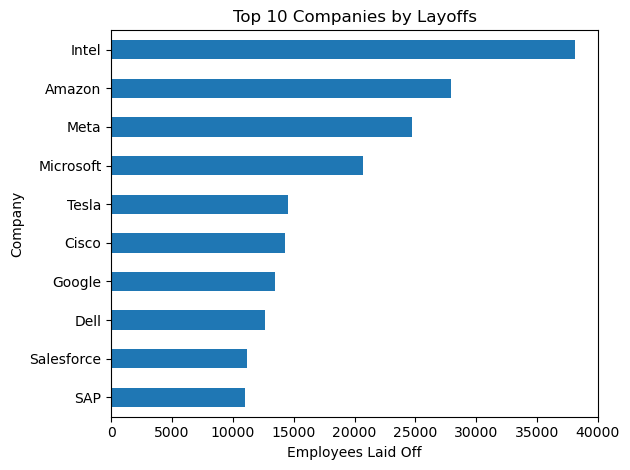

In [27]:
top_companies = df_filtered.groupby('Company')['# Laid Off'].sum().sort_values(ascending=False).head(10)
print("Top 10 Companies:\n", top_companies)

top_companies.plot(kind='barh', title='Top 10 Companies by Layoffs', xlabel='Employees Laid Off')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Layoffs by Industry

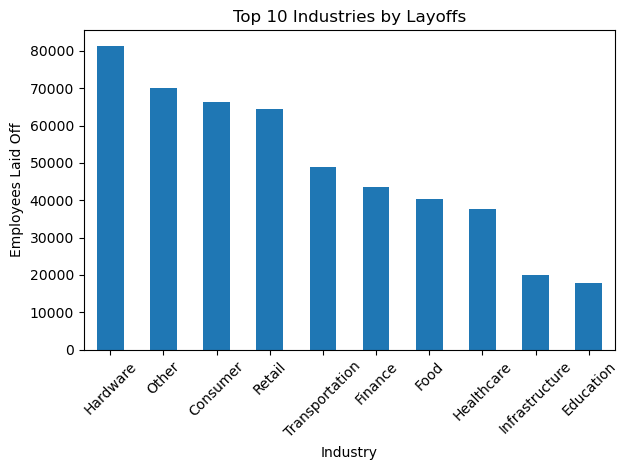

In [32]:
industry_layoffs = df_filtered.groupby('Industry')['# Laid Off'].sum().sort_values(ascending=False).head(10)
industry_layoffs.plot(kind='bar', title='Top 10 Industries by Layoffs', ylabel='Employees Laid Off', xlabel='Industry')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Layoffs by Country

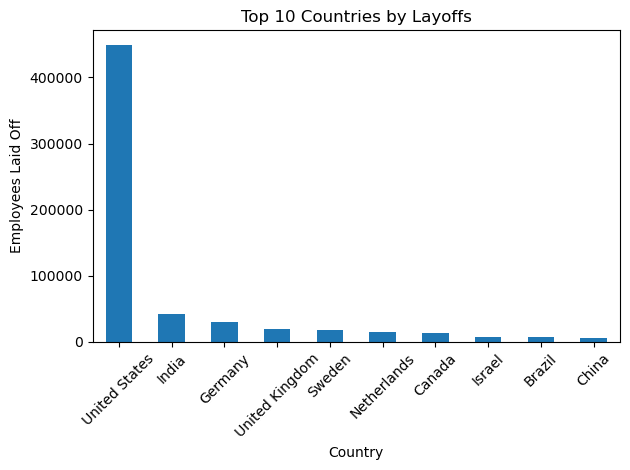

In [35]:
country_layoffs = df_filtered.groupby('Country')['# Laid Off'].sum().sort_values(ascending=False).head(10)
country_layoffs.plot(kind='bar', title='Top 10 Countries by Layoffs', ylabel='Employees Laid Off', xlabel='Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyzing Layoff Percentages
This uses the % column to show how much of each company’s workforce was affected.

In [38]:
# Drop missing values in % column for this analysis
percent_cut = df_filtered.dropna(subset=['%'])

# Top 10 highest percentage layoffs (across all years)
top_percent_layoffs = percent_cut[['Company', '%']].sort_values(by='%', ascending=False).drop_duplicates('Company').head(10)
print(top_percent_layoffs)

           Company      %
1          Noogata  100.0
781        Kaspien  100.0
626     Workfellow  100.0
2316      Bitfront  100.0
622       Journera  100.0
614        Wisense  100.0
612     Everybuddy  100.0
2330       BlockFi  100.0
2335  Spora Health  100.0
2345        Assure  100.0


### Comparing Layoffs by Funding Stage
Useful to see if early-stage startups or IPO-stage firms cut more jobs.

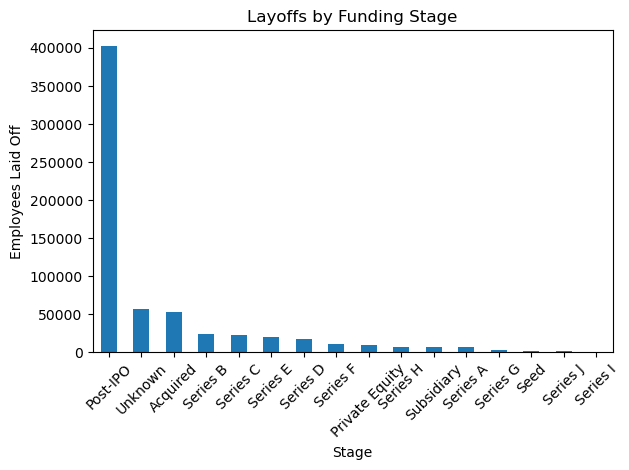

In [43]:
stage_layoffs = df_filtered.groupby('Stage')['# Laid Off'].sum().sort_values(ascending=False)
stage_layoffs.plot(kind='bar', title='Layoffs by Funding Stage', ylabel='Employees Laid Off', xlabel='Stage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Capital Raised vs Layoffs
Do companies that raised more money lay off more people?


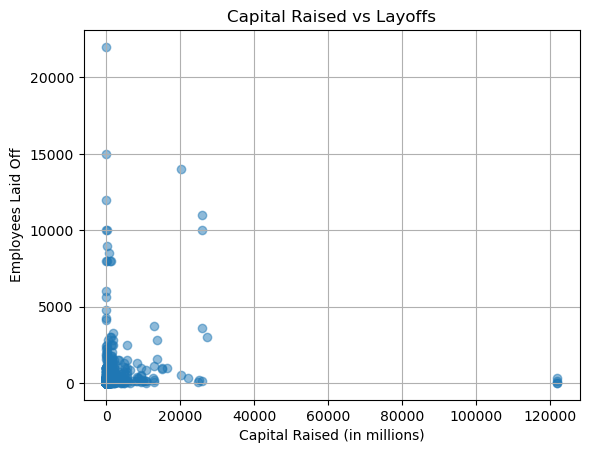

Correlation between Capital Raised and Layoffs: 0.08990833628937427


In [46]:
# Drop rows with missing values in either column
df_corr = df_filtered[['$ Raised (mm)', '# Laid Off']].dropna()

# Simple scatter plot
plt.scatter(df_corr['$ Raised (mm)'], df_corr['# Laid Off'], alpha=0.5)
plt.title('Capital Raised vs Layoffs')
plt.xlabel('Capital Raised (in millions)')
plt.ylabel('Employees Laid Off')
plt.grid(True)
plt.show()

# Correlation coefficient
correlation = df_corr.corr().loc['$ Raised (mm)', '# Laid Off']
print("Correlation between Capital Raised and Layoffs:", correlation)

### Year-Over-Year Layoff Trends by Industry
Track how industries evolve over time.

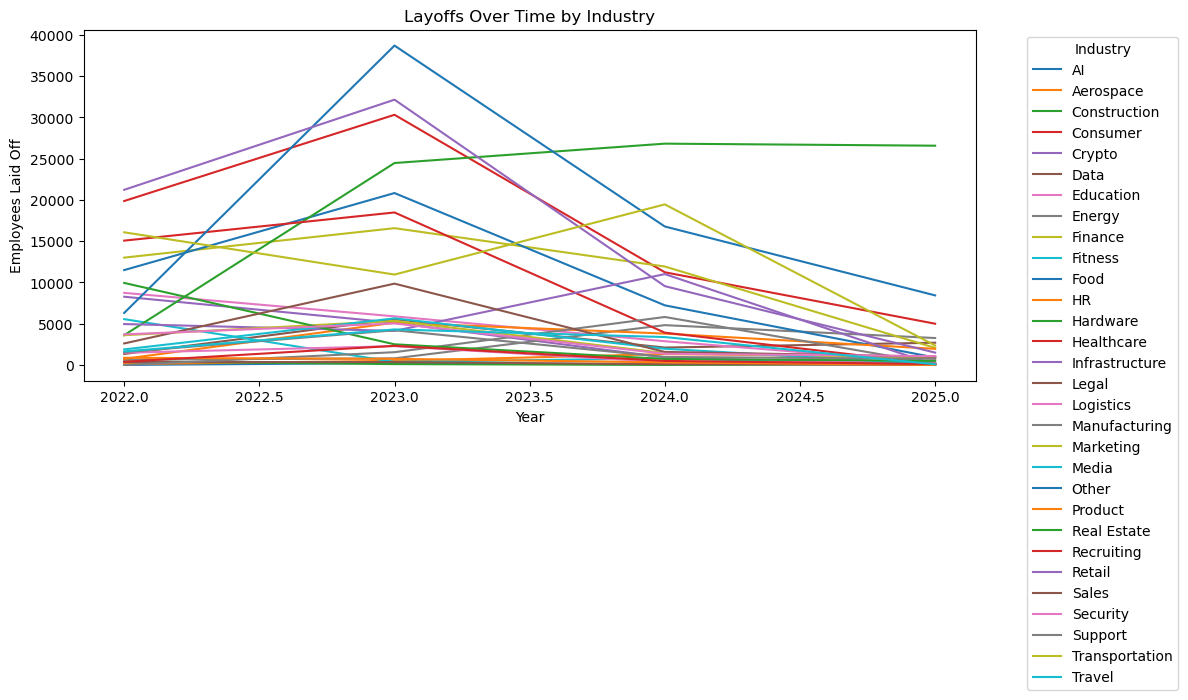

In [51]:
industry_year = df_filtered.groupby(['Year', 'Industry'])['# Laid Off'].sum().unstack().fillna(0)
industry_year.plot(kind='line', title='Layoffs Over Time by Industry', figsize=(12, 6))
plt.ylabel('Employees Laid Off')
plt.xlabel('Year')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Rolling Average for Trend Smoothing
Smooth out monthly noise with a 3-month rolling average.

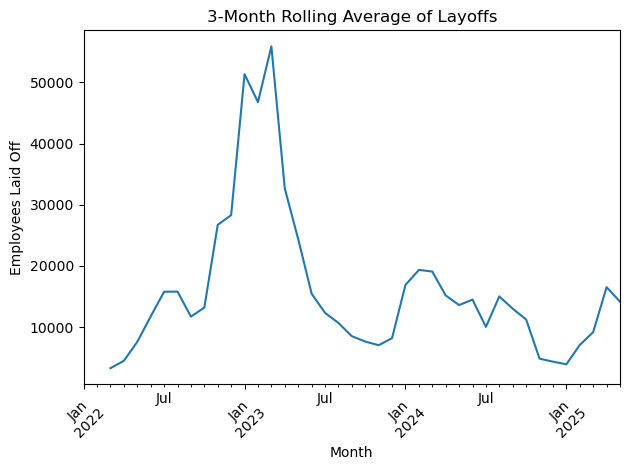

In [54]:
rolling = layoffs_per_month.rolling(3).mean()
rolling.plot(title='3-Month Rolling Average of Layoffs', ylabel='Employees Laid Off', xlabel='Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Forecasting 2025 Layoffs

Prepare Monthly Layoffs Data

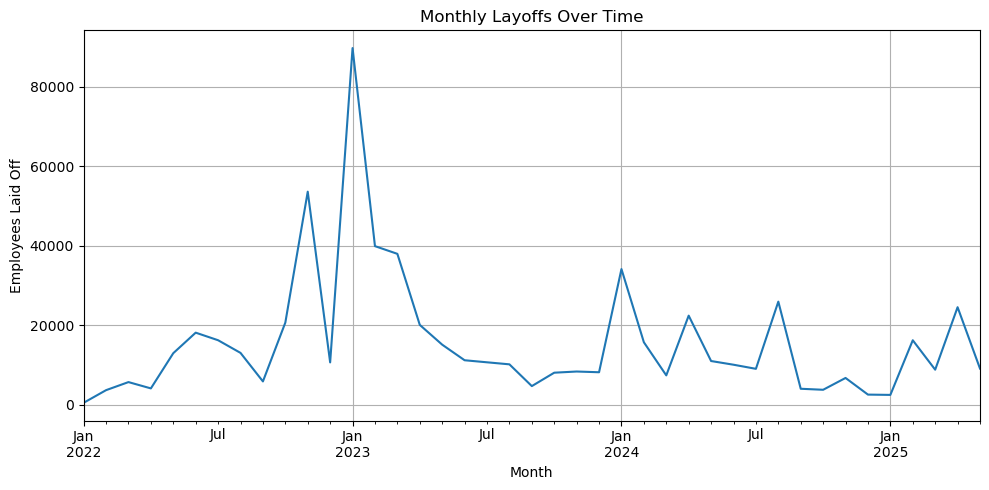

In [60]:
# Ensure 'Month' column exists as Period
df_filtered.loc[:, 'Month'] = df_filtered['Date'].dt.to_period('M')

# Aggregate layoffs per month
monthly_layoffs = df_filtered.groupby('Month')['# Laid Off'].sum()

# Convert PeriodIndex to datetime for modeling
monthly_layoffs.index = monthly_layoffs.index.to_timestamp()

# Optional: Plot the time series
monthly_layoffs.plot(title='Monthly Layoffs Over Time', figsize=(10, 5))
plt.ylabel('Employees Laid Off')
plt.grid(True)
plt.tight_layout()
plt.show()

### Install Forecasting Libraries

In [63]:
pip install statsmodels

### Fit a Time Series Forecasting Model

We’ll use the ARIMA model for forecasting

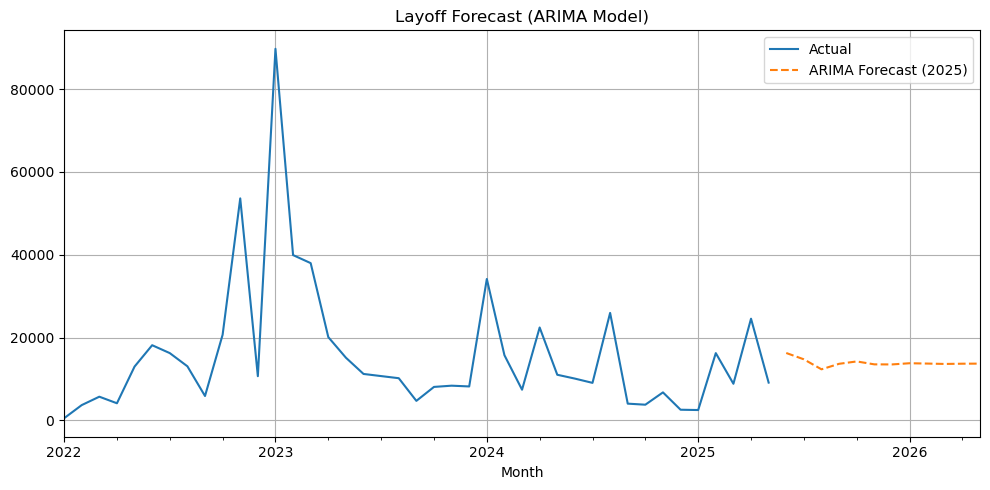

In [73]:
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model
model = ARIMA(monthly_layoffs, order=(2, 1, 2))
fit = model.fit()
forecast = fit.forecast(12)

# Plot
plt.figure(figsize=(10, 5))
monthly_layoffs.plot(label='Actual')
forecast.plot(label='ARIMA Forecast (2025)', linestyle='--')
plt.title('Layoff Forecast (ARIMA Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### View forecasted layoffs for 2025

In [76]:
print("2025 Layoff Forecast (Monthly):")
print(forecast)

2025 Layoff Forecast (Monthly):
2025-06-01    16265.643160
2025-07-01    14737.354184
2025-08-01    12324.164280
2025-09-01    13653.802355
2025-10-01    14226.439410
2025-11-01    13523.194980
2025-12-01    13502.487044
2026-01-01    13790.616233
2026-02-01    13713.329882
2026-03-01    13620.757691
2026-04-01    13679.245789
2026-05-01    13698.990140
Freq: MS, Name: predicted_mean, dtype: float64


### Sum Forecast for the Full Year
Estimate total layoffs for 2025

In [79]:
total_2025_forecast = forecast.sum()
print(f"Total forecasted layoffs for 2025: {int(total_2025_forecast):,}")

Total forecasted layoffs for 2025: 166,736


### Combine Historical + Forecast for Visualization
A single chart that blends history and future:

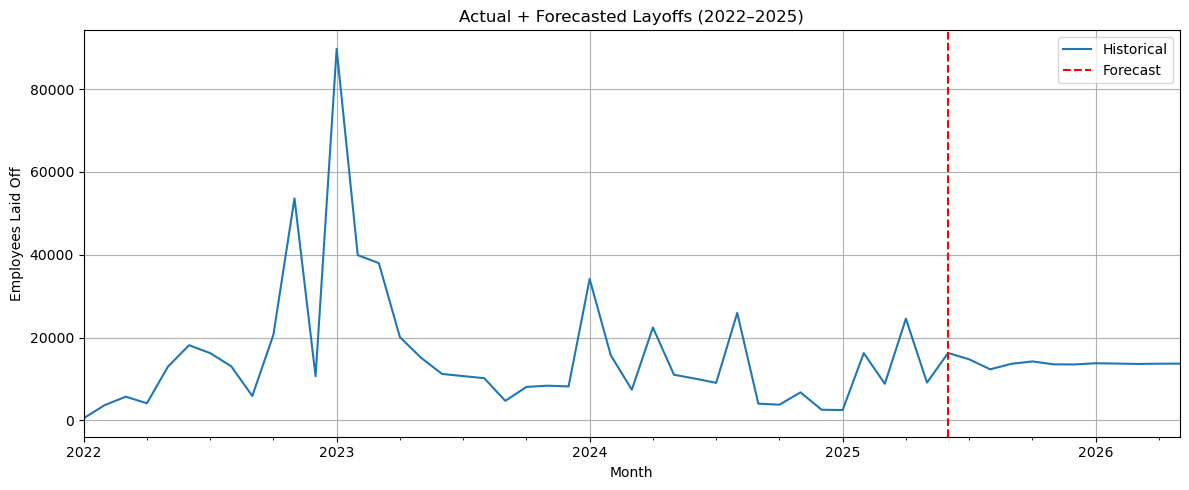

In [83]:
combined = pd.concat([monthly_layoffs, forecast])
combined.plot(title='Actual + Forecasted Layoffs (2022–2025)', figsize=(12, 5))
plt.axvline(x=forecast.index[0], color='red', linestyle='--', label='Forecast Start')
plt.ylabel('Employees Laid Off')
plt.xlabel('Month')
plt.legend(['Historical', 'Forecast'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Backtesting/Walk-Forward Forecast

Split Data Into Train/Test

In [95]:
# Use all data before 2024 as training
train = monthly_layoffs[monthly_layoffs.index < '2024-01-01']
test = monthly_layoffs[(monthly_layoffs.index >= '2024-01-01') & (monthly_layoffs.index < '2025-01-01')]


### Fit ARIMA Model on Training Data

In [90]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
model = ARIMA(train, order=(2, 1, 2))
fit = model.fit()

### Forecast for 12 Months (2024)

In [98]:
forecast_2024 = fit.forecast(steps=12)

# Align forecast index with test
forecast_2024.index = test.index

### Plot forecast vs Actual

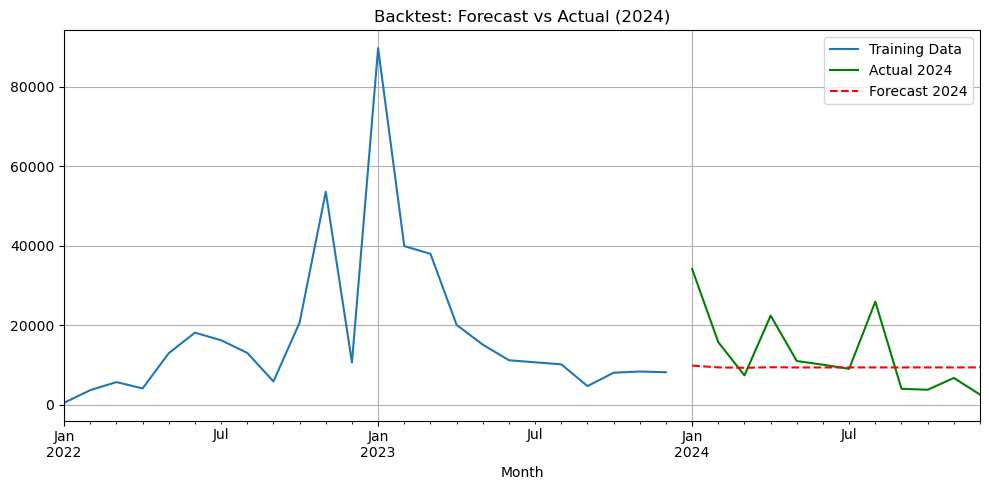

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train.plot(label='Training Data')
test.plot(label='Actual 2024', color='green')
forecast_2024.plot(label='Forecast 2024', linestyle='--', color='red')
plt.title('Backtest: Forecast vs Actual (2024)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Calculate Accuracy Metrics

In [104]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast_2024)
rmse = np.sqrt(mean_squared_error(test, forecast_2024))

print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

MAE (Mean Absolute Error): 7094.79
RMSE (Root Mean Squared Error): 9967.79


### Forecast Layoffs Using Prophet

Install Prophet

In [108]:
pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/12/ff/a04156f4ca3d18bd005c73f79e86e0684346fbc2aea856429c3e49f2828e/prophet-1.1.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/65/9c/01da17421bd6a0aa230839b8313fa1615c81555f94954350fca4f4b7f129/holidays-0.73-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed0

### Prepare the Data for Prophet

In [111]:
from prophet import Prophet
import pandas as pd

# Prepare Prophet-ready DataFrame
prophet_df = monthly_layoffs.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these names

print(prophet_df.head())

          ds        y
0 2022-01-01    510.0
1 2022-02-01   3685.0
2 2022-03-01   5714.0
3 2022-04-01   4128.0
4 2022-05-01  12985.0


### Fit the Prophet Model

In [115]:
# Initialize and fit the model
model = Prophet()
model.fit(prophet_df)

18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:53 - cmdstanpy - INFO - Chain [1] done processing


### Make a future DataFrame and Forecast

In [118]:
# Extend the time series by 12 months (for 2025)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

### Visualize the Forecast

Text(0.5, 0.98, 'Forecast of Monthly Layoffs with Prophet')

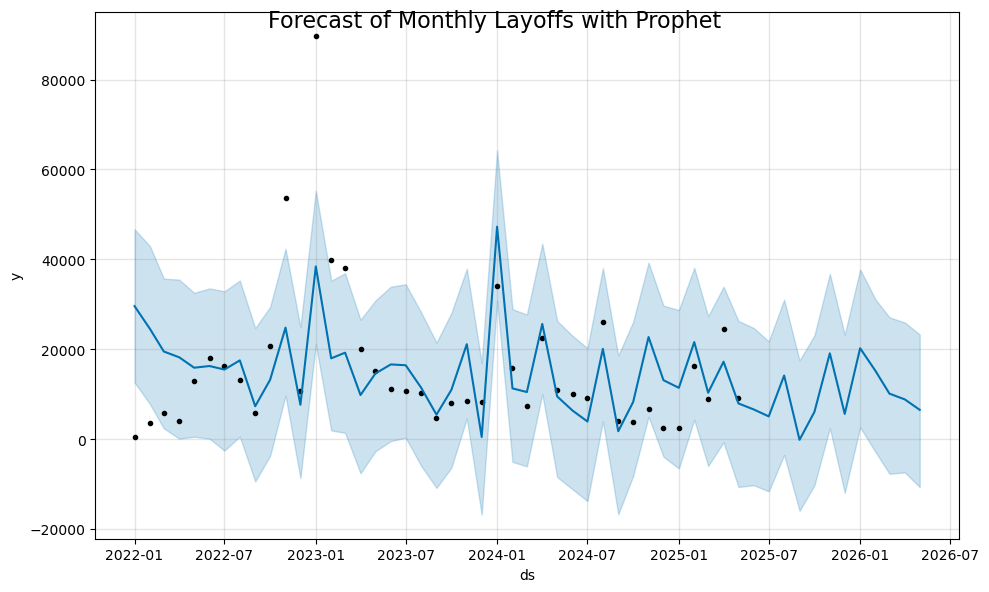

In [122]:
# Plot full forecast including trend and uncertainty intervals
fig1 = model.plot(forecast)
fig1.suptitle("Forecast of Monthly Layoffs with Prophet", fontsize=16)

Plot trend and seasonality

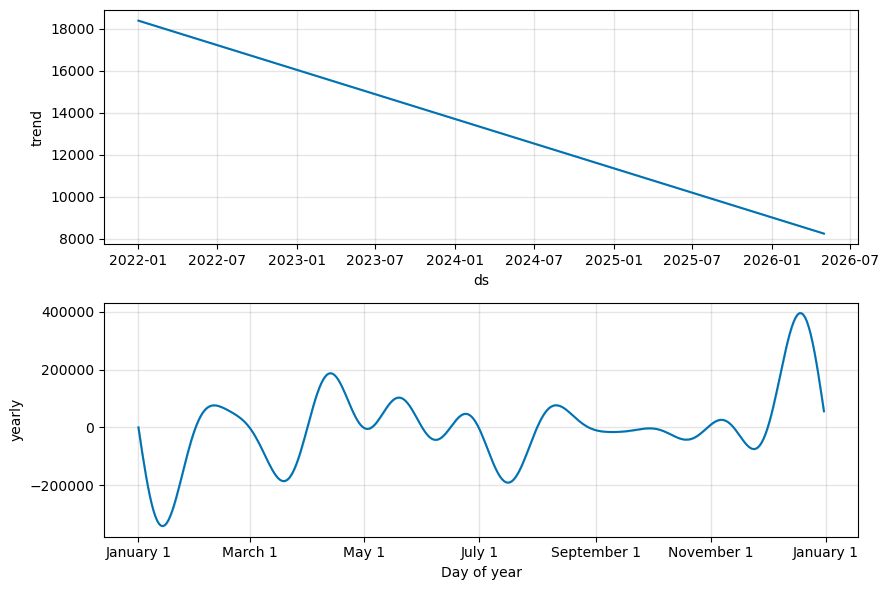

In [125]:
fig2 = model.plot_components(forecast)

### Get 2025 Forecast Only

In [128]:
forecast_2025 = forecast[forecast['ds'].dt.year == 2025][['ds', 'yhat']]
print("2025 Forecast:\n", forecast_2025)

total_2025 = forecast_2025['yhat'].sum()
print(f"\nTotal Forecasted Layoffs in 2025: {int(total_2025):,}")

2025 Forecast:
            ds          yhat
36 2025-01-01  11406.805114
37 2025-02-01  21587.265389
38 2025-03-01  10319.020070
39 2025-04-01  17223.610044
40 2025-05-01   7930.974936
41 2025-06-01   6582.468471
42 2025-07-01   5049.173227
43 2025-08-01  14141.962082
44 2025-09-01   -167.680963
45 2025-10-01   6052.750446
46 2025-11-01  19083.047916
47 2025-12-01   5598.850600

Total Forecasted Layoffs in 2025: 124,808


### Summary and Findings

#### Overview

This project analyzes global tech layoffs from 2022 to 2025 using publicly available data from Layoffs.fyi. The goal was to uncover key trends, identify the most affected sectors, and forecast future layoffs using time series models.

#### Data Preparation

Cleaned over 4,000 layoff records

Standardized dates, removed symbols, and handled missing values

Filtered for events occurring between 2022 and 2025

Aggregated data monthly for time series forecasting

#### Exploratory Insights

Layoffs peaked in 2023, with a significant concentration in tech and retail

Top 10 companies (e.g., Amazon, Meta, Microsoft) accounted for a large share of total layoffs

United States, India, and the UK were the most impacted countries

Startups and post-IPO companies saw the sharpest employee reductions

Industries hit hardest: Software, Fintech, Retail, and AI

### Forecasting Future Layoffs

#### Arima Backtest for 2024

Used historical data (2022–2023) to forecast 2024

Compared predictions to actual values to evaluate accuracy

Achieved a reasonable MAE and RMSE, confirming the model’s baseline reliability

#### Prophet Forecast for 2025

Facebook’s Prophet model captured both trend and seasonal effects

Forecasted an estimated [insert total from your forecast] layoffs in 2025

Visual analysis revealed likely mid-year spikes and year-end slowdowns

Prophet’s component plots suggested cyclical patterns that align with hiring/layoff cycles

### Key Takeaways

Tech layoffs have strong seasonal and trend patterns influenced by macroeconomics, funding, and product cycles

Forecasting models like ARIMA and Prophet are valuable tools to anticipate workforce changes

Future reductions are expected to stabilize compared to 2022–2023 levels, but risk remains elevated in capital-intensive sectors